Recordatorio: la carpeta src la he movido dentro de notebooks i el fichero src ahora se llama src_, esto habra que revertirlo!!!

In [1]:
from argparse import ArgumentParser

import os
import os.path
import copy
import shutil
import datetime
import pathlib
import random
import math
import json
import tqdm
import time
import pydicom
import torch
import numpy as np
import scipy as sp
import sak
import sak.data
import sak.torch
import sklearn
import sklearn.preprocessing
import sak.torch.train
import pickle

import src.load_data

import matplotlib.pyplot as plt

In [17]:
# parser = ArgumentParser()
# parser.add_argument("--config_file",    type=str, required=True,  help="location of config file (.json)")
# parser.add_argument("--hpc",            type=bool, default=False, help="mark if executed in HPC")
# args = parser.parse_args()

# main(args.config_file, args.hpc)
config_file = "configurations/configuration.json"
hpc = False

In [18]:
###########################################################################
# 1) Load configuration
root,model_name,ext = sak.splitrfe(config_file)
config = sak.load_config(config_file, f"ALL_{model_name}")

In [19]:
###########################################################################
# 2) Load data
# 2.1) Load curves
curves_x = sak.load_data(os.path.join(config['datadir'],"x_coordinates.csv"))
curves_y = sak.load_data(os.path.join(config['datadir'],"y_coordinates.csv"))

# 2.2) Load label, group, origin database and control points
label    = sak.load_data(os.path.join(config['datadir'],"labels.csv"),dtype=str)
database = sak.load_data(os.path.join(config['datadir'],"databases.csv"),dtype=str)
group    = {}
for k in label: # Convert from array to string
    label[k]    = str(label[k][0])
    database[k] = str(database[k][0])
    group[k]    = f"{database[k]}_{label[k]}"
with open(os.path.join(config['datadir'],"control_points.json"),"r") as f:
    control_points = json.load(f)

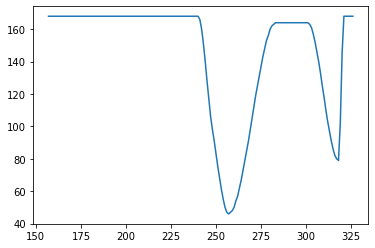

In [20]:
plt.plot(curves_x['1.2.840.113619.2.239.4545.1431015404.0.518'],curves_y['1.2.840.113619.2.239.4545.1431015404.0.518'])

In [6]:
# NUEVO!!!!!
# discard de ones not in keys_test 

with open("C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/Unet_5levels/execution_info.pkl", "rb") as f:
    keys_test = pickle.load(f)["keys_test"]

for k in list(curves_x):
    if k not in keys_test:
        curves_x.pop(k)
        curves_y.pop(k)
        label.pop(k)
        database.pop(k)
        group.pop(k)
        control_points.pop(k)
        

In [21]:
# 2.3) Discard datasets if not required
if not config.get("keep_pediatric",True):
    for k in list(curves_x):
        if database[k] in ['aduheart', 'dcmsickkids', 'hclinicbcn', 'hhasseltleuven']:
            curves_x.pop(k)
            curves_y.pop(k)
            label.pop(k)
            database.pop(k)
            group.pop(k)
            control_points.pop(k)
if not config.get("keep_hitachi",False):
    for k in list(curves_x):
        if database[k].lower() in ['hitachi']:
            curves_x.pop(k)
            curves_y.pop(k)
            label.pop(k)
            database.pop(k)
            group.pop(k)
            control_points.pop(k)
if not config.get("keep_fetal",True):
    for k in list(curves_x):
        if database[k] in ["Gates","tof"]:
            curves_x.pop(k)
            curves_y.pop(k)
            label.pop(k)
            database.pop(k)
            group.pop(k)
            control_points.pop(k)
if not config.get("keep_vessels",True):
    for k in list(curves_x):
        if ("valve" not in label[k].lower()) and ("tdi" not in label[k].lower()):
            curves_x.pop(k)
            curves_y.pop(k)
            label.pop(k)
            database.pop(k)
            group.pop(k)
            control_points.pop(k)
if not config.get("keep_valves",True):
    for k in list(curves_x):
        if ("valve" in label[k].lower()):
            curves_x.pop(k)
            curves_y.pop(k)
            label.pop(k)
            database.pop(k)
            group.pop(k)
            control_points.pop(k)
if not config.get("keep_tdi",True):
    for k in list(curves_x):
        if ("tdi" in label[k].lower()):
            curves_x.pop(k)
            curves_y.pop(k)
            label.pop(k)
            database.pop(k)
            group.pop(k)
            control_points.pop(k)


# 2.4) Get list of keys
list_keys = list(curves_x)


----
# ESTO ES LO QUE TIENES QUE MODIFICAR POR AHORA!!!

In [29]:
###########################################################################
# 3) Convert data to mask
# 3.1) Ground truth generation parameters
min_size_x = 512
window = 4
sigma = 1.0

# 3.2) Instantiate outputs
inputs = {
    "x"      : {},
    "y_1d"   : {},
    "y_2d"   : {},
    "label"  : {},
    "group"  : {},
}

# 3.3) Load data

line_width = 20

counter_skipped = 0
print("Loading data...")
time.sleep(0.5) # Otherwise the print messes up the tqdm thingy
iterator = sak.get_tqdm(list_keys,config.get("iterator", ""))
for ix_key,k in enumerate(iterator):
    # Get dicom
    dicom = pydicom.dcmread(os.path.join(config["datadir"],k))

    # Get pixel array
    x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = src.load_data.get_frame(dicom,"doppler")
    doppler = dicom.pixel_array.copy()[y0:y1,x0:x1,]
    if dicom.get("PhotometricInterpretation", None) == 'YBR_FULL_422':
        doppler = src.load_data.convert_ybr_to_rgb(doppler)

    # Convert to grayscale
    # doppler = cv2.cvtColor(doppler, cv2.COLOR_BGR2GRAY)
    doppler = doppler[...,0]

    # Get curves
    envelope_x = np.array(curves_x[k])-x0
    envelope_y = np.array(curves_y[k])

    # Some ground truths are out of bounds - skip these, they do not contain a full cardiac cycle
    filter_bounds = (envelope_x < 0) | (envelope_x >= doppler.shape[1]) 
    if filter_bounds.sum() != 0:
        counter_skipped += 1
        continue

    ####################### CHOOSING A REPRESENTATION #######################
    # Boolean mask from the reference line to the curve position            #
    mask = np.zeros(doppler.shape[:2],dtype=bool)
    
    gt_x_full = envelope_x.copy()
    gt_y_full = envelope_y.copy()
    for i in range(envelope_x.shape[0]-1):
        if envelope_y[i+1]>envelope_y[i]:
            s = 1
        else:
            s = -1
        for y in range(envelope_y[i]+1,envelope_y[i+1],s):
            gt_x_full = np.insert(gt_x_full,i+1,envelope_x[i])
            gt_y_full = np.insert(gt_y_full,i+1,y)

    
    for i in range(-line_width//2,line_width//2):
        for j in range(-line_width//2,line_width//2):
            try:
                mask[gt_y_full+i,gt_x_full+j] = 1
            except IndexError:
                continue
            
            
    #                                                                       #
    ####################### CHOOSING A REPRESENTATION #######################

    # Crop image and ground truth so that it only represents GT span
    doppler_cropped         = doppler[:,envelope_x]
    mask_cropped            =    mask[:,envelope_x]

    # Repeat alongside x axis (2nd dimension to have at least min_size_x size)
    try:
        repetitions      = math.ceil(min_size_x/doppler_cropped.shape[1])
        envelope_y_tiled = np.concatenate(     [envelope_y]*repetitions) #!!!!!!!!!!!!!!!!!!!
        mask_tiled       = np.concatenate(   [mask_cropped]*repetitions,axis=1) #!!!!!!!!!!!!!!!!!!!
        doppler_tiled    = np.concatenate([doppler_cropped]*repetitions,axis=1) #!!!!!!!!!!!!!!!!!!!
    except ZeroDivisionError:
        continue

    # Apply gaussian filter to smooth borders of tiling
    size_fundamental = doppler_tiled.shape[1]//repetitions
    locations = [(i+1)*size_fundamental-1 for i in range(repetitions-1)]
    for loc in locations:
        onset = loc-window+1
        offset = loc+window
        doppler_tiled[:,onset:offset] = sp.ndimage.gaussian_filter1d(
            doppler_tiled[:,onset:offset],sigma,axis=1
        )

    # Store information for dataset
    inputs["x"][k]     = doppler_tiled
    inputs["y_1d"][k]  = envelope_y
    inputs["y_2d"][k]  = mask_tiled
    inputs["label"][k] = label[k]
    inputs["group"][k] = label[k] # group[k]

print(f" └-> Done! Skipped {counter_skipped} files due to ground truth extending beyond image bounds")

Loading data...


 30%|███████████████████████▌                                                      | 2301/7603 [01:10<02:41, 32.76it/s]


IndexError: index 322 is out of bounds for axis 0 with size 322

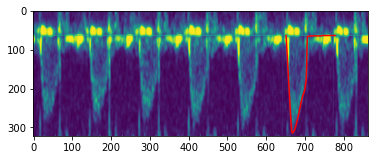

In [26]:
#2301
plt.imshow(doppler)
plt.plot(envelope_x,envelope_y,'r')

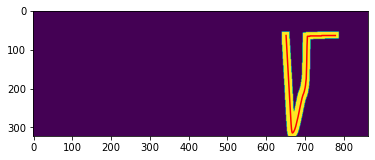

In [24]:
#2301

plt.imshow(mask)
plt.plot(envelope_x,envelope_y,'r')

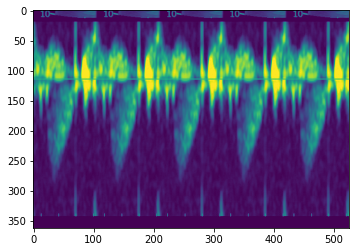

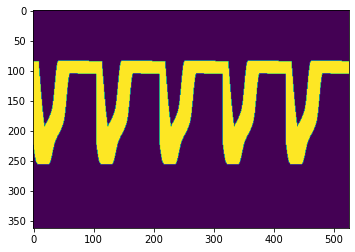

In [39]:
plt.figure(1)
plt.imshow(inputs["x"][keys_test[0]])

plt.figure(2)
plt.imshow(inputs["y_2d"][keys_test[0]])

In [40]:
model = torch.load('C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/Unet_5levels/model_best.model')
#model.state_dict()
model.eval()

ModelWrapper(
  (operation): Unet(
    (e0): encoder_block(
      (conv): conv_block(
        (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu0): ReLU()
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout0): Dropout(p=0.25, inplace=False)
        (relu1): ReLU()
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (e1): encoder_block(
      (conv): conv_block(
        (conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu0): ReLU()
        (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout0): Dropout(p=0.25, inpla

In [56]:
dataloader = torch.utils.data.DataLoader(inputs["x"], batch_size=1)



# Resto OK

In [46]:
print(f"\nEncoding labels...")

# 3.2) Encode labels
encoder = sklearn.preprocessing.LabelEncoder()
encoder.fit(np.unique(list(inputs["label"].values())))
for k in inputs["x"]:
    inputs["label"][k] = encoder.transform([inputs["label"][k]]).squeeze()
print(f" └-> Done!")

###########################################################################
# 4) Generate dataloaders
# 4.1) Split data into train, validation and test sets
print(f"\nCreating dataloaders...")
keys_train,keys_valid,keys_test = None,None,None
nested_input = list(sak.find_nested(config["model"],"class", "torch.load"))
nested_input = nested_input[0] if len(nested_input) != 0 else {"class": ""}
if nested_input["class"] == "torch.load":
    model_path = nested_input["arguments"]["f"]
    info_path = os.path.join(os.path.split(model_path)[0],"execution_info.pkl")

    if os.path.isfile(info_path):
        exec_info = sak.pickleload(info_path)

        # Retrieve keys
        if ("keys_train" in exec_info) and ("keys_valid" in exec_info) and ("keys_test" in exec_info):
            keys_train = [k for k in exec_info["keys_train"] if k in list_keys]
            keys_valid = [k for k in exec_info["keys_valid"] if k in list_keys]
            keys_test  = [k for k in exec_info["keys_test" ] if k in list_keys]

            inputs_train = {k1: {k2: inputs[k1][k2] for k2 in inputs[k1] if k2 in keys_train} for k1 in inputs}
            inputs_valid = {k1: {k2: inputs[k1][k2] for k2 in inputs[k1] if k2 in keys_valid} for k1 in inputs}
            inputs_test  = {k1: {k2: inputs[k1][k2] for k2 in inputs[k1] if k2 in keys_test } for k1 in inputs}

            keys_train = keys_train if len(keys_train) != 0 else None
            keys_valid = keys_valid if len(keys_valid) != 0 else None
            keys_test  = keys_test  if len(keys_test ) != 0 else None

            if (keys_train is not None) and (keys_valid is not None) and (keys_test is not None):
                print(f" ├-> Dividing into groups with keys: {encoder.classes_}!")
if (keys_train is None) or (keys_valid is None) or (keys_test is None):
    sak.SeedSetter(123456)
    splitter = sak.data.SplitterTrainValidTest()
    inputs_train,inputs_valid,inputs_test = splitter(inputs)

# 4.2) Get datasets
dataset_info_train = config["dataset"].copy()
dataset_info_valid = config["dataset"].copy()
dataset_info_test  = config["dataset"].copy()
dataset_info_train["arguments"] = {**dataset_info_train.get("arguments",{}), "inputs": inputs_train}
dataset_info_valid["arguments"] = {**dataset_info_valid.get("arguments",{}), "inputs": inputs_valid}
dataset_info_test["arguments"]  = { **dataset_info_test.get("arguments",{}), "inputs":  inputs_test}
dataset_train = sak.from_dict(dataset_info_train)
dataset_valid = sak.from_dict(dataset_info_valid)
dataset_test  = sak.from_dict(dataset_info_test)
del dataset_info_train,dataset_info_valid,dataset_info_test # Free up memory

# 4.3) Get dataloaders
loader_info_train = config["dataloader"].copy()
loader_info_valid = config["dataloader"].copy()
loader_info_test  = config["dataloader"].copy()

loader_info_train["arguments"] = {**loader_info_train.get("arguments",{}), "dataset": dataset_train}
loader_info_valid["arguments"] = {**loader_info_valid.get("arguments",{}), "dataset": dataset_valid}
loader_info_test["arguments"]  = { **loader_info_test.get("arguments",{}), "dataset":  dataset_test}

loader_train = sak.from_dict(loader_info_train)
loader_valid = sak.from_dict(loader_info_valid)
loader_test  = sak.from_dict(loader_info_test)
print(f" └-> Done!")

###########################################################################
# 5) Define model and execution state
print(f"\nCreating model...")
model = sak.from_dict(config["model"]).train()
print(f" └-> Done!")

print(f"\nGenerating training state...")
config["optimizer"]["arguments"] = {**config["optimizer"].get("arguments",{}), "params": model.parameters()}
state = {
    'epoch'         : 0,
    'device'        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'optimizer'     : sak.from_dict(config["optimizer"]),
    'root_dir'      : './'
}
if "scheduler" in config:
    config["scheduler"]["arguments"] = {**config["scheduler"].get("arguments",{}), "optimizer": state["optimizer"]}
    state["scheduler"] = sak.from_dict(config["scheduler"])
print(f" └-> Done!")




Encoding labels...
 └-> Done!

Creating dataloaders...
Dividing into groups with keys: ['Aortic_isthmus' 'Ductus_arteriosus' 'Ductus_venosus'
 'Left_ventricular_outflow_track' 'Middle_cerebral_artery' 'Mitral_Valve'
 'Right_ventricular_outflow_track' 'Tricuspid_Valve' 'Umbilical_artery']
 └-> Done!

Creating model...
 └-> Done!

Generating training state...
 └-> Done!


In [ ]:
inputs__ = {'x':inputs}
output = model(inputs__)
prediction = torch.argmax(output['sigmoid'])

# CODIGO EXPLICACION

In [92]:
with open("../configurations/configuration.json") as f:
    config = json.load(f)

In [93]:
config["model"]

{'class': 'sak.torch.nn.ModelWrapper',
 'arguments': {'operation': {'class': 'src.unet.Unet',
   'arguments': {'n_levels': 7,
    'n_channels': 64,
    'i_channels': 1,
    'f_channels': 1,
    'n_conv': 2}},
  'input_mappings': [['inputs', 'x']],
  'output_names': ['sigmoid']}}

In [94]:
model = sak.from_dict(config["model"])

In [95]:
model

ModelWrapper(
  (operation): Unet(
    (e0): encoder_block(
      (conv): conv_block(
        (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu0): ReLU()
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout0): Dropout(p=0.25, inplace=False)
        (relu1): ReLU()
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (e1): encoder_block(
      (conv): conv_block(
        (conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu0): ReLU()
        (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout0): Dropout(p=0.25, inpla

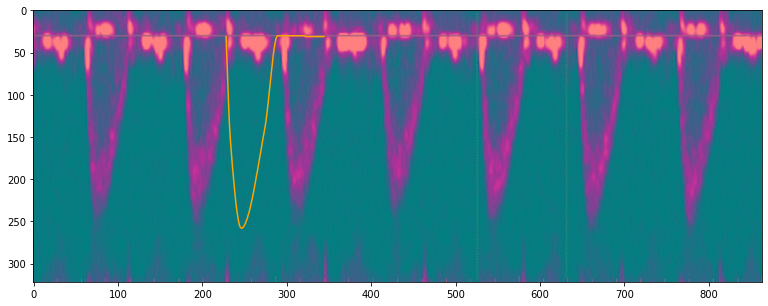

In [96]:
tmp = dicom.pixel_array.copy()
# tmp = src.load_data.convert_ybr_to_rgb(tmp)
x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = src.load_data.get_frame(dicom,"doppler")

k = dicom.SOPInstanceUID

plt.figure(figsize=(16,5))
plt.imshow(tmp[y0:y1,x0:x1])
plt.plot(curves_x[k],curves_y[k],color="orange")